In [1]:
import pandas as pd
import numpy as np

import controls
import models

import matplotlib.pyplot as plt

In [2]:
SEIR = models.SEIR()

# 10 day prediction horizon
opt = controls.OptimalControl(SEIR, H=10)

t_incubation = 5.1
t_infective = 3.3
R0 = 2.4

# Population (DK)
N = 1e5
max_infected = 2000 # % of N

opt.X_ub[2] = max_infected / N
opt.U_lb[0] = 0
opt.U_ub[0] = 0.8

# Initial number of infected and recovered individuals
e0 = 1/N
i0 = 0
r0 = 0
s0 = 1 - e0 - i0 - r0
x0 = [s0, e0, i0, r0]

p0 = [1/t_incubation, R0/t_infective, 1/t_infective]

In [ ]:
N_days = 365
X_sim = np.zeros((SEIR.x.size, N_days))
U_sim = np.zeros((1, N_days))
X_sim[:,0] = x0

F_RK4 = SEIR.get_rk4_single_step()
MPC = opt.get_MPC()

# Simulate
init = 0
for k in range(N_days-1):
    U_sim[:,k], init = MPC(X_sim[:,k], p0, init)
    X_sim[:,k+1] = F_RK4(X_sim[:,k], U_sim[:,k], p0).toarray().flatten()

In [7]:
# Results
sim_result = pd.DataFrame(
    np.vstack((X_sim, U_sim)).T, 
    columns=SEIR.x.keys() + [SEIR.u.name()]
)

In [8]:
# Baseline, no social distancing
simulator = F_RK4.mapaccum(N_days)
sim_result_baseline = pd.DataFrame(
    simulator(x0, 0, p0).toarray().T,
    columns=SEIR.x.keys()
)

Text(0.5, 0, 'Days')

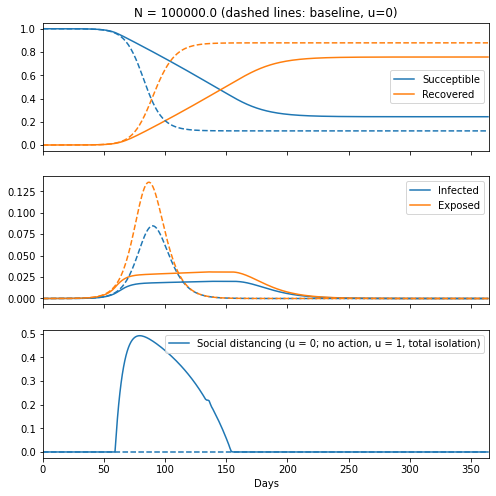

In [9]:
fig, axes = plt.subplots(3,1, figsize=(8,8), sharex=True)

axes[0].set_title("N = {} (dashed lines: baseline, u=0)".format(N))

sim_result[["s", "r"]].plot(ax=axes[0])
axes[0].set_prop_cycle(None)
sim_result_baseline[["s", "r"]].plot(style='--', ax=axes[0])
axes[0].legend(["Succeptible", "Recovered"])


sim_result[["i", "e"]].plot(ax=axes[1])
axes[1].set_prop_cycle(None)
sim_result_baseline[["i", "e"]].plot(style='--', ax=axes[1])
axes[1].legend(["Infected", "Exposed"])

sim_result[["u"]].plot(ax=axes[2])
axes[2].set_prop_cycle(None)
plt.plot(sim_result.index, np.zeros(365), '--')
axes[2].legend(["Social distancing (u = 0; no action, u = 1, total isolation)"])

axes[2].set_xlim([0, 365])
axes[2].set_xlabel("Days")